In [1]:
import pandas as pd
import numpy as np
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.utils import to_categorical
import pickle
from keras.applications import VGG16
from keras.models import Model
import matplotlib.pyplot as plt
%matplotlib inline

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### load the data we saved

In [2]:
da = pickle.load(open('da10c.pkl','rb'))

### use the pretrained model VGG16 from keras, default training is on imagenet dataset
### I also tried resnet50 and [keras vgface](https://github.com/rcmalli/keras-vggface) models

In [3]:
model = VGG16()

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### here i used layer with output (7,7,512), i also tried with using layer fc2 with output 4096 

In [5]:
model.layers.pop()

In [6]:
model.layers.pop()

In [7]:
model.layers.pop()

In [8]:
model.layers.pop()

In [10]:
model.layers[-1].output

<tf.Tensor 'block5_pool/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>

In [11]:
model = Model(model.inputs, model.layers[-1].output)

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [13]:
da.columns

Index(['age', 'path', 'ne_age'], dtype='object')

### remeber my data distrubtion

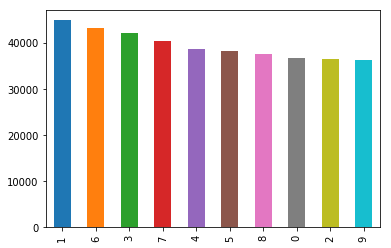

In [14]:
da['ne_age'].value_counts().plot.bar()

### i also tried creating dicionary with each class weight from sklearn libary to use it in train keras model in loss function

In [15]:
#from sklearn.utils import class_weight

In [16]:
#cw = class_weight.compute_class_weight('balanced', np.unique(da['ne_age']), da['ne_age'])

In [17]:
#cw

array([1.07389599, 0.87889902, 1.0830128 , 0.93650813, 1.01969838,
       1.03436106, 0.91128603, 0.97793297, 1.04794502, 1.08902671])

In [18]:
#dw = dict()

In [19]:
#for i in range(10):
    #dw[i] = cw[i]

In [20]:
#dw

{0: 1.073895987141417,
 1: 0.8788990212035406,
 2: 1.0830128029012582,
 3: 0.9365081250593937,
 4: 1.0196983806715298,
 5: 1.0343610600892155,
 6: 0.9112860346302333,
 7: 0.977932967823563,
 8: 1.0479450233943004,
 9: 1.0890267149211261}

In [21]:
#pickle.dump(dw,open('dw.pkl','wb'))

In [ ]:
# this takes around 4 hours even on aws !
X,Y = [],[]
cnt = 0
for i,r in da.iterrows():
    path = 'imdb_crop/' + r['path']
    # load image with keras image utils
    img = image.load_img(path, target_size=(224, 224))
    img = image.img_to_array(img)
    # reshape with batch_size for model
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    # preprocess_input provided by keras, should take care of normizling image
    img = preprocess_input(img)
    feature = model.predict(img, verbose=0)[0]
    X.append(feature)
    # encode age prediction
    y = to_categorical(r['ne_age'], num_classes=10)
    Y.append(y)
    # create training files each with 2048 data point, as dataset is too big to be loaded into memory
    if len(X) % 2048 == 0:
        cnt += 1
        print(cnt)
        x1 = np.array(X)
        y1 = np.array(Y)
        pickle.dump([x1,y1],open('trainfiles/train' + str(cnt) + '.pkl', 'wb'))
        del X,Y,x1,y1
        X,Y = [],[]

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


1
